In [2]:
!pip install torch torchvision 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [3]:
import pandas as np 
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torch.utils.data import random_split
import torchvision 
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder 
from torchvision.utils import make_grid

In [4]:
data_path_train=('/kaggle/input/x-ray-data/train')
data_path_test=('/kaggle/input/x-ray-data/test')

In [6]:
img_size = 120 
img_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
                                    

In [9]:
train_data=ImageFolder(root=data_path_train,transform=img_transform)
test_data=ImageFolder(root=data_path_test,transform=img_transform)

In [10]:
len(train_data),len(test_data)

(189, 66)

In [11]:
train_data.class_to_idx

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [12]:
val_data, test_data=random_split(test_data,[50,16])

In [13]:
len(val_data),len(test_data)

(50, 16)

In [14]:
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
val_loader=DataLoader(val_data,batch_size=16,shuffle=True)

In [15]:
for img, label in train_loader:
    print(img.shape)
    break

torch.Size([16, 3, 120, 120])


In [21]:
def show_img(data):
    for img,label in data:
        plt.figure(figsize=(12,6))
        plt.imshow(make_grid(img,nrow=5).permute(1,2,0))
        plt.show()
        break

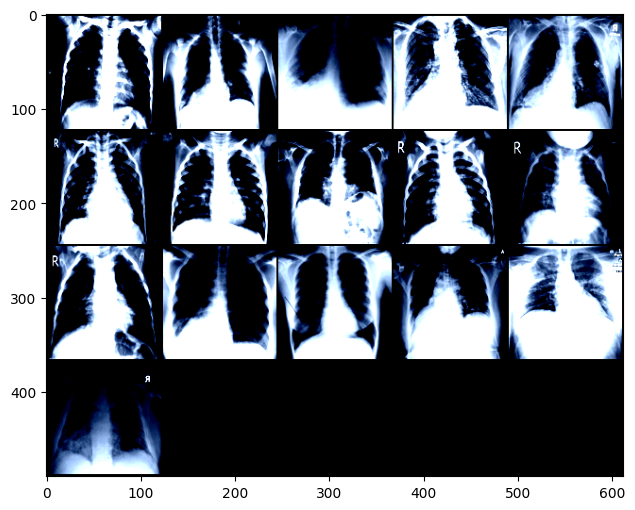

In [24]:
show_img(train_loader)

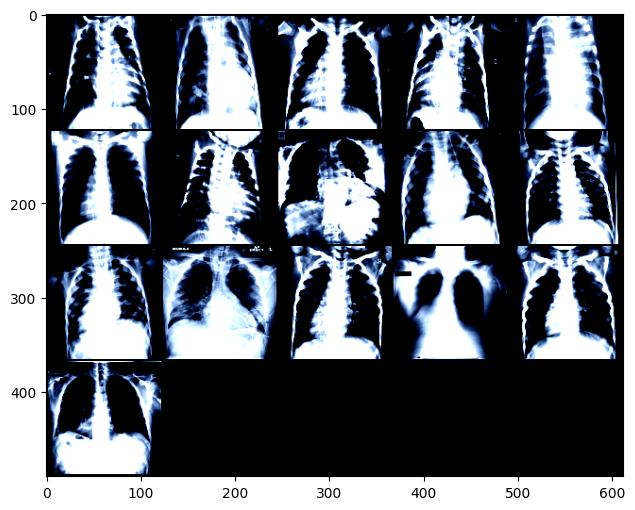

In [23]:
show_img(val_loader)

In [31]:
class ANN(nn.Module):
    def __init__(self,hidden_layer=64):
        super(ANN,self).__init__()

        self.fc1=nn.Linear(120*120*3, hidden_layer)
        self.fc2=nn.Linear(hidden_layer,3)


        self.relu=nn.ReLU()

    def forward(self,img):
        out=img.view(-1,120*120*3)
        out=self.fc1(out)
        out=self.relu(out)
        out=self.fc2(out)

        return out
        

In [33]:
model=ANN()
print(model.parameters)

<bound method Module.parameters of ANN(
  (fc1): Linear(in_features=43200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)>


In [35]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001)

In [45]:
def train(model,loss_fn,optimizer):

    epochs=15

    training_loss=[]
    training_acc=[]
    validation_loss=[]
    validation_acc=[]


    for epoch in range(epochs):
        train_loss=0.0
        train_acc=0.0

        model.train()

        for images,labels in train_loader:

            optimizer.zero_grad()

            output=model(images)
            loss=loss_fn(output,labels)

            loss.backward()
            optimizer.step()


            predictions=torch.argmax(output,1)

            train_acc += (predictions==labels).sum().item()

            train_loss += loss.item()

        training_acc.append(train_acc/len(train_data))
        training_loss.append(train_loss/len(train_loader))

        val_loss=0.0
        val_acc=0.0

        with torch.no_grad():
            for images,labels in val_loader:

                output = model(images)
                loss = loss_fn(output,labels)

                predictions = torch.argmax(output,1)

                val_acc += (predictions == labels).sum().item()
                val_loss += loss.item()

        validation_loss.append(val_loss/len(val_loader))
        validation_acc.append(val_acc/len(val_data))


        print("Epochs {} , Training Acc {:.2f},Training Loss {:.2f} , Validation Acc {:.2f}, Validation Loss {:.2f}.".format(
            epoch+1,train_acc/len(train_data),train_loss/len(train_loader),val_acc/len(val_data),val_loss/len(val_loader)
        ))

    plt.title("Accuracy vs Epoch")
    plt.plot(range(epochs),training_acc,label="training Accuracy")
    plt.plot(range(epochs), validation_acc, label="Validation Accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Training/Validation Accuracy")
    plt.show()

    plt.title("Loss vs Epoch")
    plt.plot(range(epochs),training_loss,label="training Loss")
    plt.plot(range(epochs), validation_loss, label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Training/Validation Loss")
    plt.show()

Epochs 1 , Training Acc 0.90,Training Loss 0.32 , Validation Acc 0.82, Validation Loss 0.48.
Epochs 2 , Training Acc 0.89,Training Loss 0.28 , Validation Acc 0.84, Validation Loss 0.44.
Epochs 3 , Training Acc 0.94,Training Loss 0.22 , Validation Acc 0.66, Validation Loss 1.16.
Epochs 4 , Training Acc 0.94,Training Loss 0.21 , Validation Acc 0.70, Validation Loss 0.57.
Epochs 5 , Training Acc 0.93,Training Loss 0.20 , Validation Acc 0.76, Validation Loss 0.38.
Epochs 6 , Training Acc 0.96,Training Loss 0.18 , Validation Acc 0.76, Validation Loss 0.46.
Epochs 7 , Training Acc 0.94,Training Loss 0.17 , Validation Acc 0.90, Validation Loss 0.31.
Epochs 8 , Training Acc 0.96,Training Loss 0.15 , Validation Acc 0.90, Validation Loss 0.38.
Epochs 9 , Training Acc 0.96,Training Loss 0.15 , Validation Acc 0.80, Validation Loss 0.32.
Epochs 10 , Training Acc 0.96,Training Loss 0.14 , Validation Acc 0.84, Validation Loss 0.33.
Epochs 11 , Training Acc 0.98,Training Loss 0.12 , Validation Acc 0.8

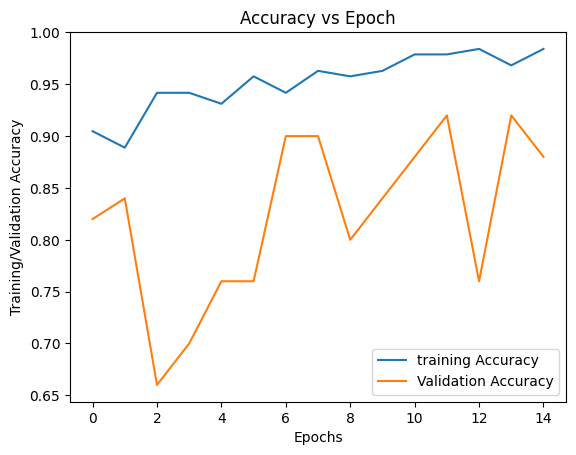

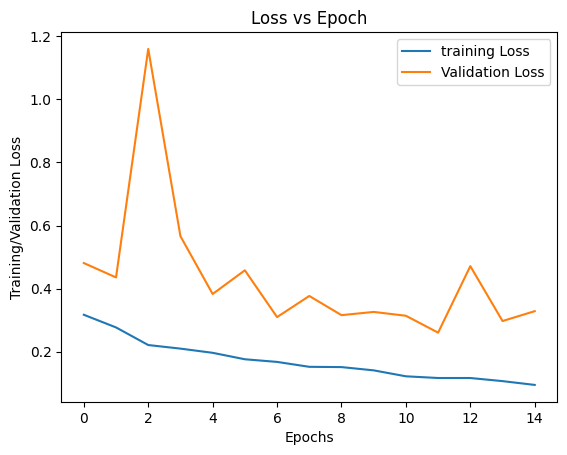

In [46]:
train(model,loss_fn,optimizer)

In [49]:
def predict_img(img,model):
    x = img.unsqueeze(0)
    y = model(x)

    pred=torch.argmax(y,dim=1)

    return train_data.classes[pred]
    

Actual label : Viral Pneumonia || Prediction Label : Viral Pneumonia


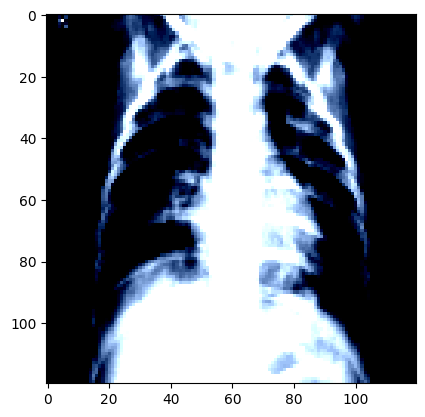

In [52]:
img , label = test_data[2]
plt.imshow(img.permute(1,2,0))
print("Actual label :",train_data.classes[label], 
"||" " Prediction Label :", predict_img(img,model))

Actual label : Normal || Prediction Label : Normal


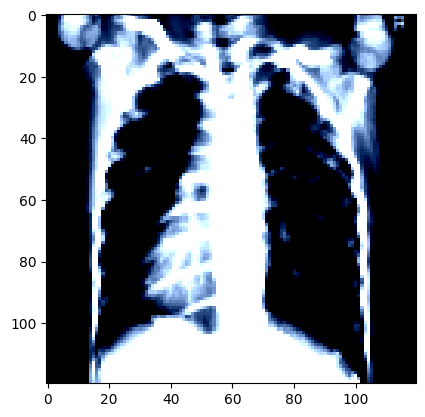

In [56]:
img , label = test_data[10]
plt.imshow(img.permute(1,2,0))
print("Actual label :",train_data.classes[label], 
"||" " Prediction Label :", predict_img(img,model))

Actual label : Covid || Prediction Label : Covid


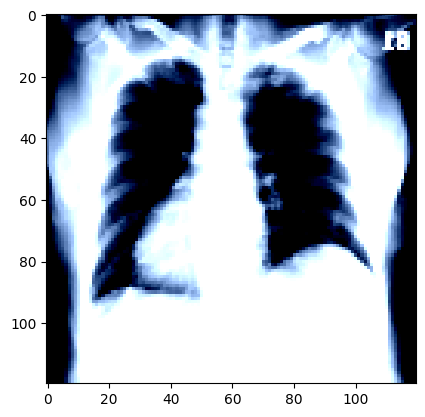

In [59]:
img , label = test_data[14]
plt.imshow(img.permute(1,2,0))
print("Actual label :",train_data.classes[label], 
"||" " Prediction Label :", predict_img(img,model))

In [11]:
torch.save(model.state_dict(), "model.pth")

In [3]:
!pip install gradio 

  Using cached gradio-5.33.0-py3-none-any.whl.metadata (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 32.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 105.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.9 MB/s eta 0:00:00


In [5]:
!pip install Pillow


In [12]:
import gradio as gr
from PIL import Image
import torch
from torchvision import transforms
from torchvision import models


# Load model (same as your existing notebook)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # assuming 2 classes
model.load_state_dict(torch.load("model.pth", map_location=device))
model = model.to(device)
model.eval()

class_names = ["Normal", "Pneumonia"]

# Image transform (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Prediction function
def predict_image(img):
    if isinstance(img, Image.Image):
        image_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            label = class_names[predicted.item()]
            return f"Prediction: {label}"
    return "Invalid image input"

# Gradio UI
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Medical Image Disease Classifier",
    description="Upload a Chest X-ray image. The model will predict if it's Normal or Pneumonia."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://0ea10745c6b7d4b97f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
iface.launch(share=True)  # use share=True for a public link
